In [48]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [57]:
data=pd.read_csv('ida_2016_training_set_update.csv')

In [58]:
def na_count(column):
    
    '''Counts number of na's in each column and returns the column name and the count'''

    count=0
    for value in data[column]:
        if value=='na':
            count=count+1
    return column,count

In [59]:
bad_columns=[]
for column in data.columns:
    column,count=na_count(column)
    if count/60000>=0.5:
        print(column,count/60000)
        bad_columns.append(column)

ab_000 0.77215
bm_000 0.65915
bn_000 0.7334833333333334
bo_000 0.7722166666666667
bp_000 0.7956666666666666
bq_000 0.8120333333333334
br_000 0.8210666666666666
cr_000 0.77215


In [5]:
data['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [6]:
#Separating class from train_data

class_label=data['class']

pre_data=data.drop(columns='class',inplace=False)

In [7]:
#Replacing 'pos' with 1 and 'neg' with 0

class_label=class_label.replace(['pos'],1)
class_label=class_label.replace(['neg'],0)


In [60]:
#Replacing 'na' with np.nan 

pre_data=pre_data.replace(['na'],np.nan)

In [9]:
#Converting all the values into float type

pre_data=pre_data.astype(float,copy=True)

In [10]:
#Storing the features which have NAN values more than 50%

pre_data=pre_data.drop(columns=bad_columns,inplace=False)

In [11]:
pre_data.shape

(60000, 162)

In [12]:
pre_data.head()

aa_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  ag_002  \
0  76698.0  2.130706e+09   280.0     0.0     0.0     0.0     0.0     0.0   
1  33058.0  0.000000e+00     NaN     0.0     0.0     0.0     0.0     0.0   
2  41040.0  2.280000e+02   100.0     0.0     0.0     0.0     0.0     0.0   
3     12.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0     0.0   
4  60874.0  1.368000e+03   458.0     0.0     0.0     0.0     0.0     0.0   

   ag_003   ag_004  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0     0.0  37250.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1     0.0  18254.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   
2     0.0   1648.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0   
3   318.0   2212.0  ...      240.0      46.0      58.0      44.0      10.0   
4     0.0  43752.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0   

     ee_007    ee_008  ee_009  ef_000  eg_000  
0  157956.0   73224.0     0.0     0.0     0.0  
1   81140.0   97576.0  1500.0     0.0     0.0  
2  158022.0   95128.0   514.0     0.0     0.0  
3       0.0       0.0     0.0     4.0    32.0  
4  311560.0  433954.0  1218.0     0.0     0.0  

[5 rows x 162 columns]

In [13]:
#Dropping the columns with std=0

for column in pre_data.columns:
    if np.std(pre_data[column])==0:
        pre_data=pre_data.drop(columns=column,inplace=False)

In [14]:
pre_data.shape

(60000, 161)

<AxesSubplot:>

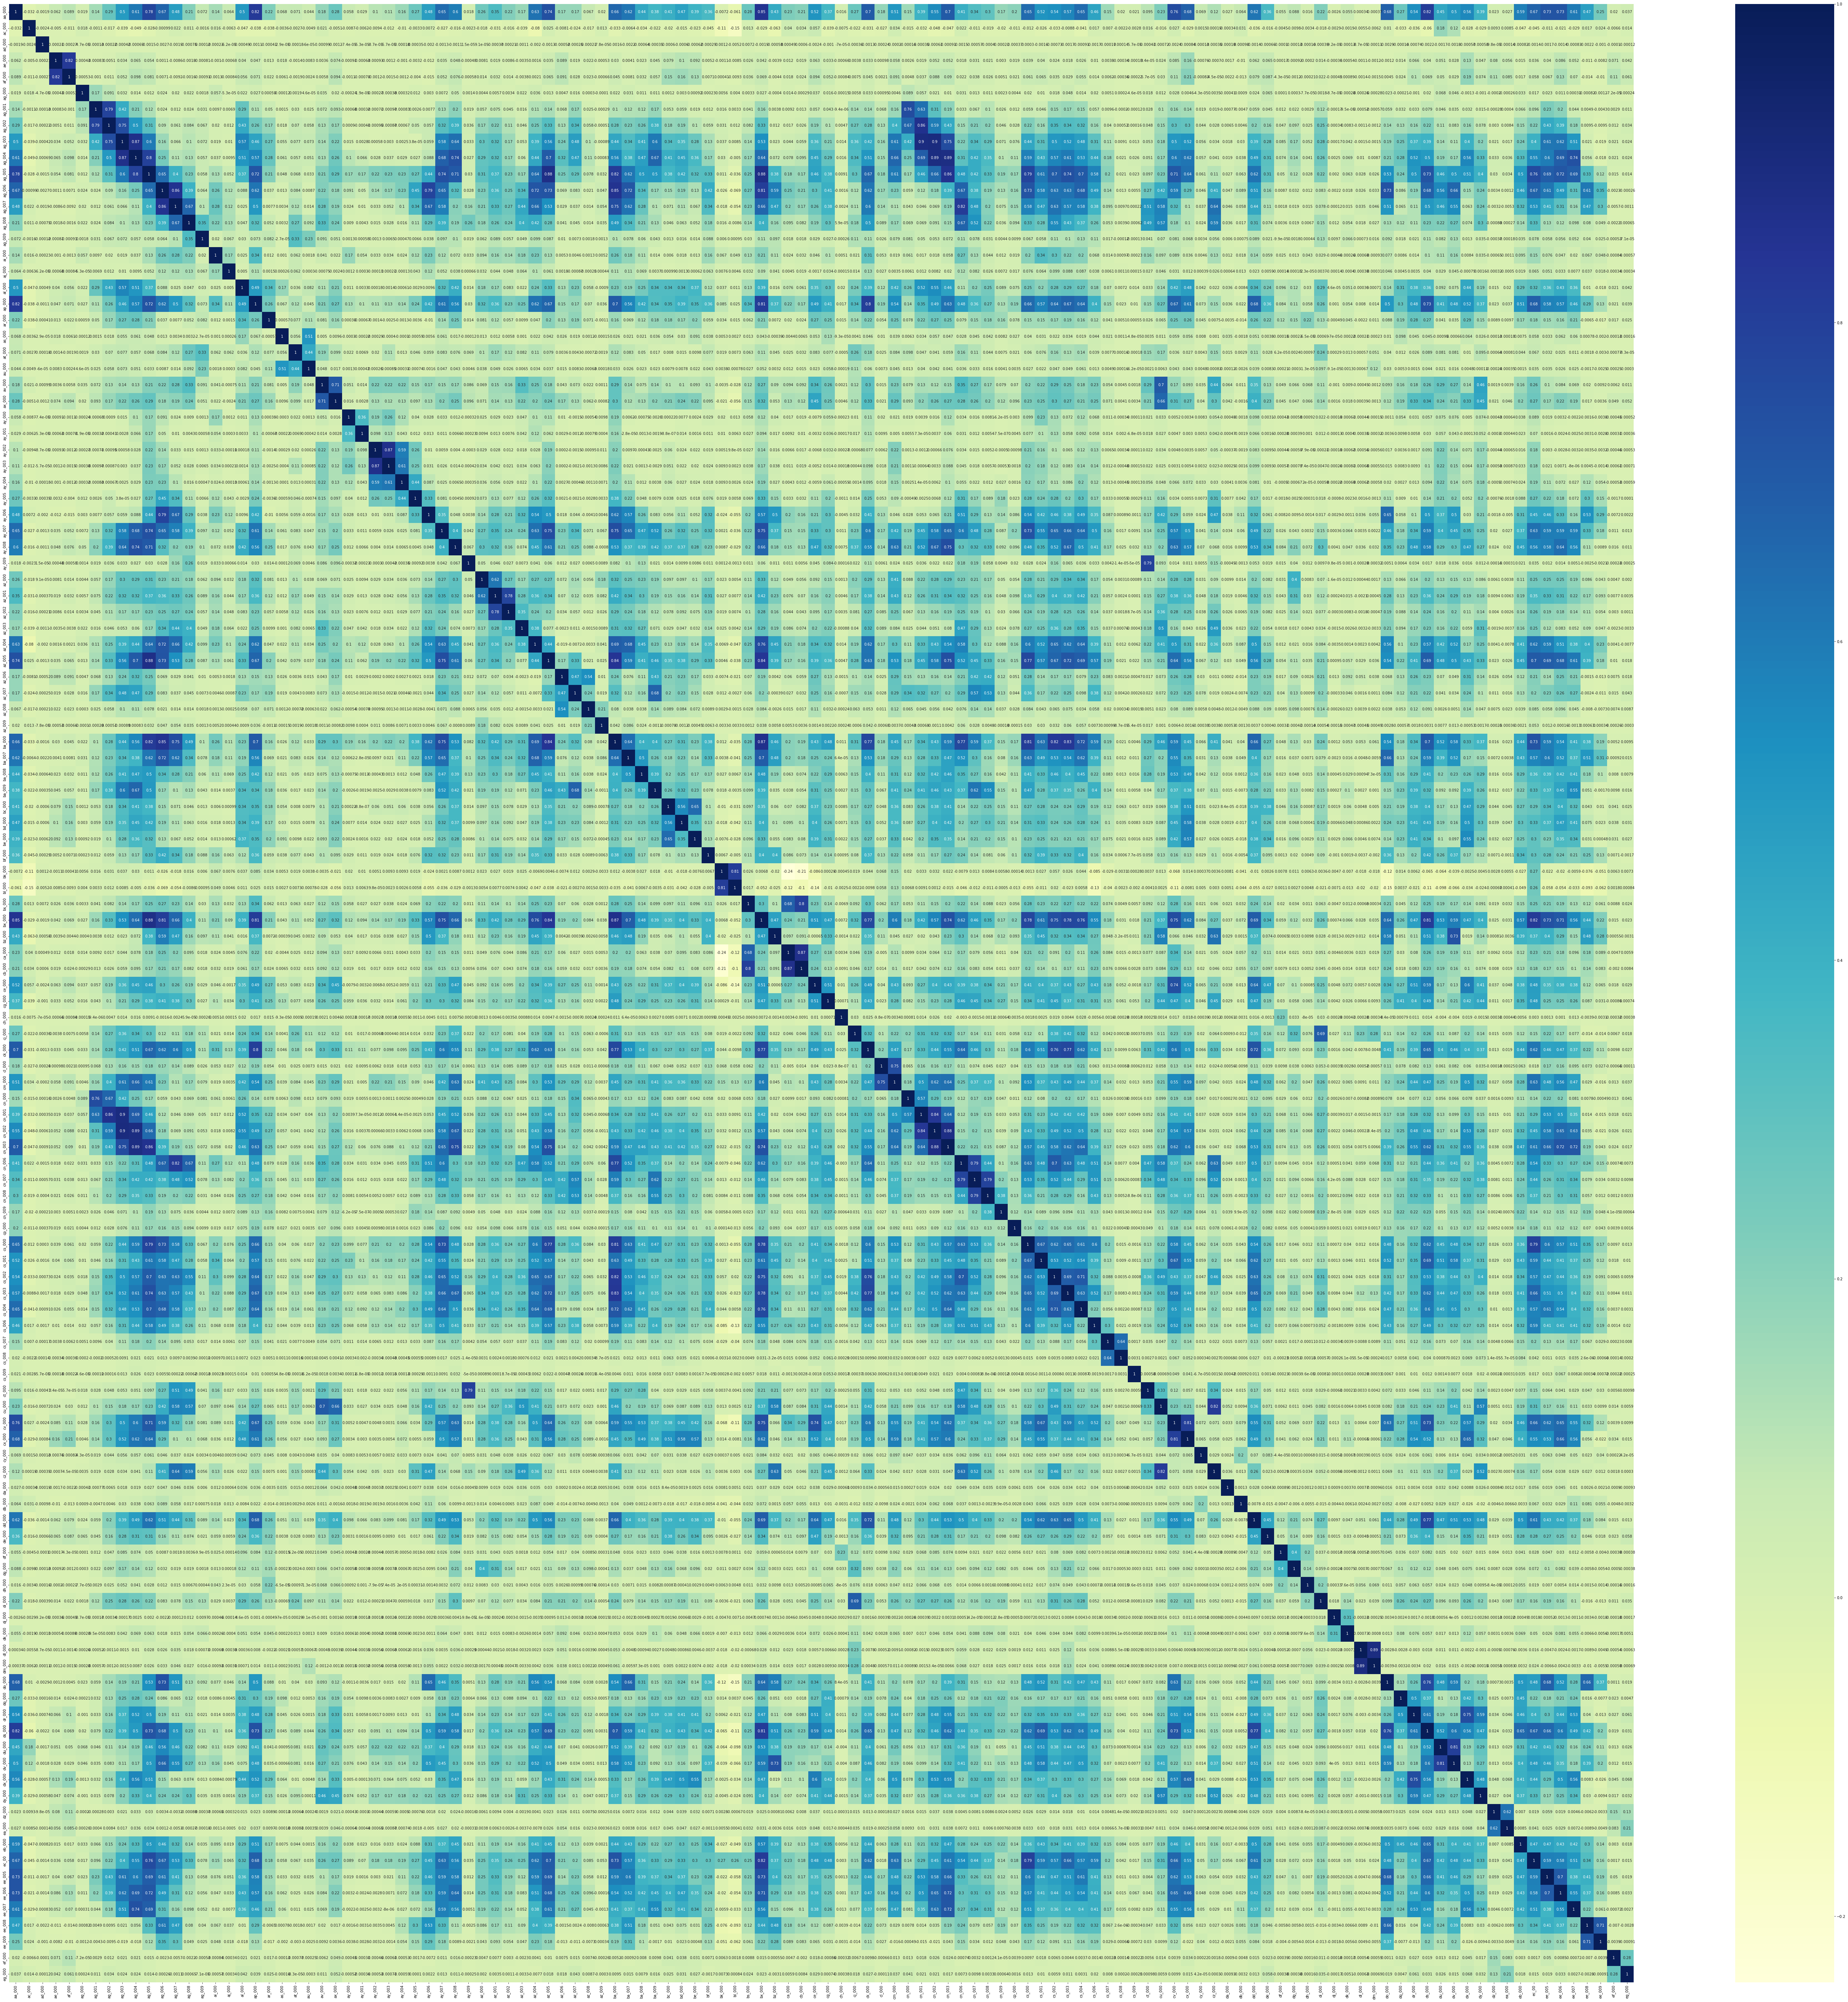

In [82]:
# Displaying the correlation matrix

plt.figure(figsize=(100,100))
sns.heatmap(pre_data.corr(), cmap="YlGnBu", annot=True)
  

In [16]:
#Dropping the columnns with high correlation

#Evaluates the upper traiangular of the matrix and whichever column has correlation above 90% is stored.
#Code Ref-https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

cor_matrix = pre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
pre_data = pre_data.drop(columns=to_drop,inplace=False)

In [17]:
pre_data.shape

(60000, 122)

In [57]:
indices_column_list_up=[]
indices_column_list_down=[]

outlier_count_column_up=[]
outlier_count_column_down=[]


for column in pre_data:
    
    index_list_up=[]
    index_list_down=[]
    
    outlier_count_up=None
    outlier_count_down=None
    
    a=pre_data[column].quantile(0.25)
    b=pre_data[column].quantile(0.75)
    
    outlier_up=b+2*(b-a)
    outlier_down=a-2*(b-a)
    
    index_list_up=pre_data.index[pre_data[column]>outlier_up].tolist()
    index_list_down=pre_data.index[pre_data[column]<outlier_down].tolist()
    
    outlier_count_up=len(index_list_up)
    outlier_count_down=len(index_list_down)
    
    indices_column_list_up.append(index_list_up)
    indices_column_list_down.append(index_list_down)
    
    outlier_count_column_up.append(outlier_count_up)
    outlier_count_column_down.append(outlier_count_down)
    
       

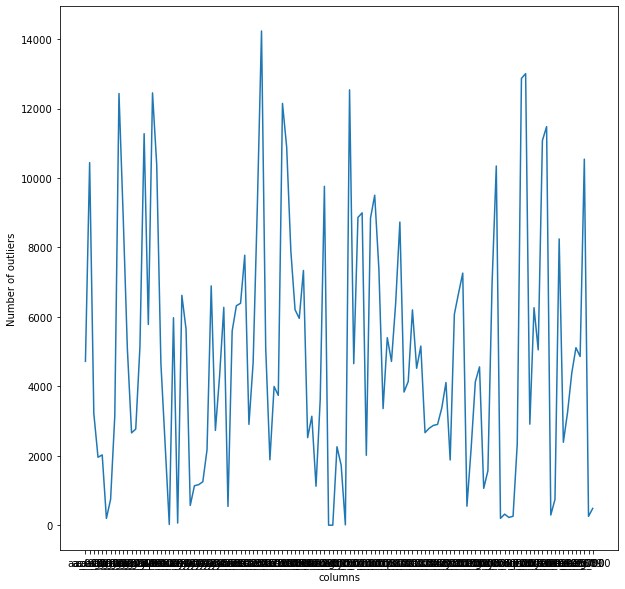

In [77]:
# Number of upper-bound outliers per column

plt.figure(figsize=(10,10))
plt.xlabel('columns')
plt.ylabel('Number of outliers')

display(plt.plot(pre_data.columns,outlier_count_column_up))



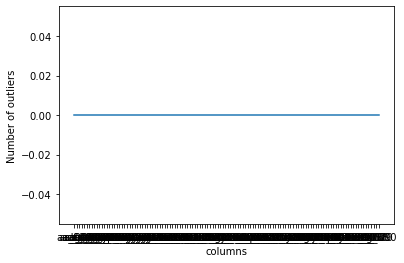

In [78]:
# Number of lower-bound outliers per column
plt.xlabel('columns')
plt.ylabel('Number of outliers')
display(plt.plot(pre_data.columns,outlier_count_column_down))

In [72]:
# finding pos class in outliers per column

pos_count_list=[]
fraction_list=[]

count_index=0
for index_list in indices_column_list_up:
    pos_count=0
    for index in index_list:
        if class_label[index]==0:
            pos_count=pos_count+1
    
    if outlier_count_column_up[count_index]!=0:
        fraction=pos_count/outlier_count_column_up[count_index]
    else:
        fraction=0
    
    pos_count_list.append(pos_count)
    fraction_list.append(fraction)
    
    count_index=count_index+1
    
    

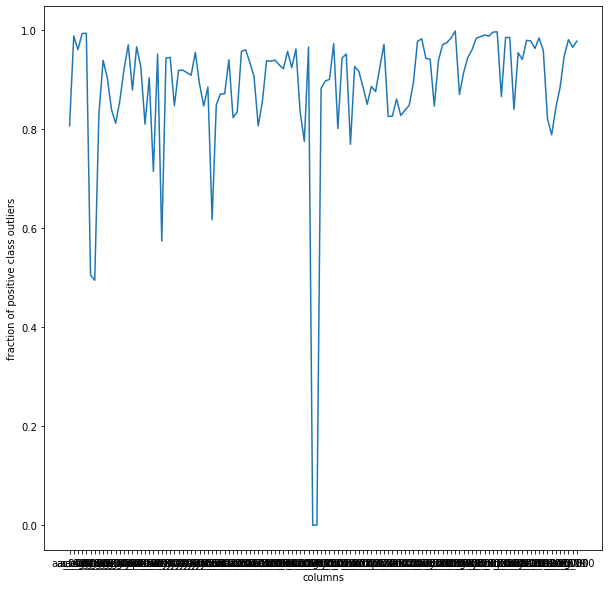

In [76]:
# Number of positive class outliers out of total outliers

plt.figure(figsize=(10,10))
plt.xlabel('columns')
plt.ylabel('fraction of positive class outliers')
display(plt.plot(pre_data.columns,fraction_list))

# Since most of the outliers belong to the positive class, outliers was not removed in this case.

In [15]:
#Imputation of the missing values

import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(min_value=0)

imp.fit(pre_data)

imputed_df=imp.transform(pre_data)

imputed_df=pd.DataFrame(imputed_df,columns=pre_data.columns)

In [85]:
#Using PCA to reduce dimensions for visualisation

from sklearn import decomposition
pca=decomposition.PCA()

pca.n_components=2
pca_data=pca.fit_transform(imputed_df)

In [91]:
#Concatenating labels and pca_data

pca_data_labels=np.vstack((pca_data.T,np.array(class_label))).T

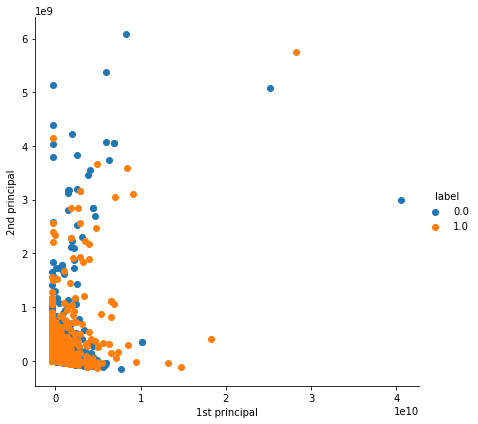

In [94]:
#Scatter Plot

pca_data_df=pd.DataFrame(data=pca_data_labels,columns=('1st principal','2nd principal','label'))
sns.FacetGrid(pca_data_df,hue='label',size=6).map(plt.scatter,'1st principal','2nd principal').add_legend()
plt.show()

In [70]:
#Using t-sne for dimensionality reduction

import numpy as np
from sklearn.manifold import TSNE

tsne_data= TSNE(n_components=2,perplexity=15).fit_transform(imputed_df)


In [71]:
#Concatenating labels and pca_data

tsne_data_labels=np.vstack((tsne_data.T,np.array(class_label))).T

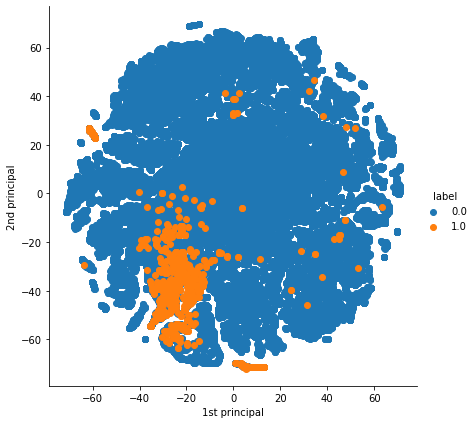

In [72]:
#Scatter Plot

tsne_data_df=pd.DataFrame(data=tsne_data_labels,columns=('1st principal','2nd principal','label'))
sns.FacetGrid(tsne_data_df,hue='label',size=6).map(plt.scatter,'1st principal','2nd principal').add_legend()
plt.show()

In [55]:
#Top numerical and histogram features extracted using using forward feature selection.

num_fea=['aa_000', 'av_000', 'bc_000', 'bk_000', 'bz_000', 'cg_000', 'ck_000', 'cl_000', 'cu_000', 'cy_000', 'da_000', 'dg_000', 'dx_000', 'dy_000', 'ef_000']

hist_fea=['ag_002', 'ag_004', 'ay_008', 'az_001', 'az_005', 'cn_002', 'cn_007','cn_009', 'cs_000', 'cs_002', 'cs_003', 'ee_005', 'ee_006', 'ee_009']

In [40]:
def EDA(fea):
    
    '''Plots Histogram,Box Plot,Violin Plot and calculates mean,median,std and Inter Quartile Range'''

    #Histogram

    sns.FacetGrid(train_data, hue="class", size=8) \
    .map(sns.distplot,fea) \
    .add_legend();
    plt.show();

    #Box Plot
    train_data[fea]=train_data[fea].astype(float)
    sns.boxplot(x='class',y=fea, data=train_data)
    plt.show()

    #Violin Plot
    sns.violinplot(x="class", y=fea, data=train_data, size=8)
    plt.show()

    #Mean,Median,std

    print('For Negative Class\n')

    print('median',train_data[fea][train_data['class']=='neg'].median())

    print('mean',train_data[fea][train_data['class']=='neg'].mean())

    print('std',train_data[fea][train_data['class']=='neg'].std())

    print('quantile',train_data[fea][train_data['class']=='neg'].quantile([0.25,0.5,0.75]))

    print('\nFor Positive Class\n')

    print('median',train_data[fea][train_data['class']=='pos'].median())

    print('mean',train_data[fea][train_data['class']=='pos'].mean())

    print('std',train_data[fea][train_data['class']=='pos'].std())

    print('quantile',train_data[fea][train_data['class']=='pos'].quantile([0.25,0.5,0.75]))

# EDA of top 5 numerical features

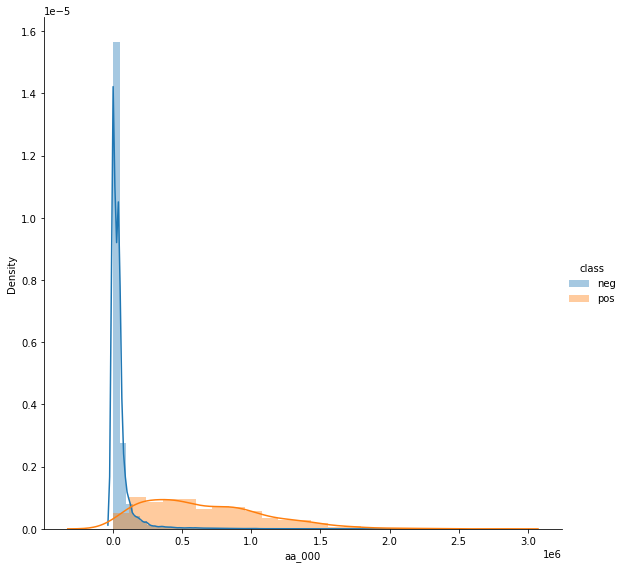

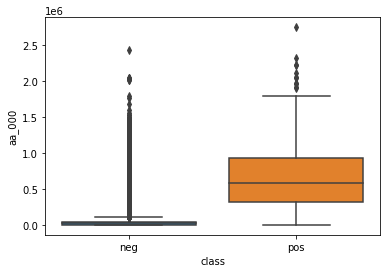

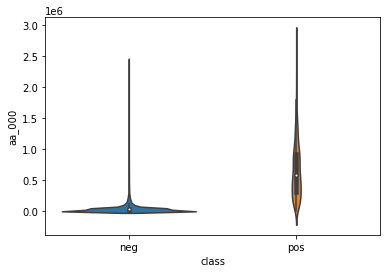

For Negative Class

median 30416.0
mean 49169.767966101695
std 110052.48134851531
quantile 0.25      784.0
0.50    30416.0
0.75    45493.0
Name: aa_000, dtype: float64

For Positive Class

median 584994.0
mean 659173.664
std 434383.8784658364
quantile 0.25    318157.5
0.50    584994.0
0.75    930501.5
Name: aa_000, dtype: float64


In [43]:
EDA('aa_000')

# aa_000

## 1) From Histogram and PDF it is observed that there is a significant difference     between positive and negative datapoints, except a slight overlap.

## 2) Box Plot and Viloin Plot- Both classes can be distinguished easily, there is  a significant difference between both the IQRs.

## 3)  Median- Mean,Median of the positive class is much higher than the       negative class.

## 4) IQR of the positive class is much higher than the negative class. 

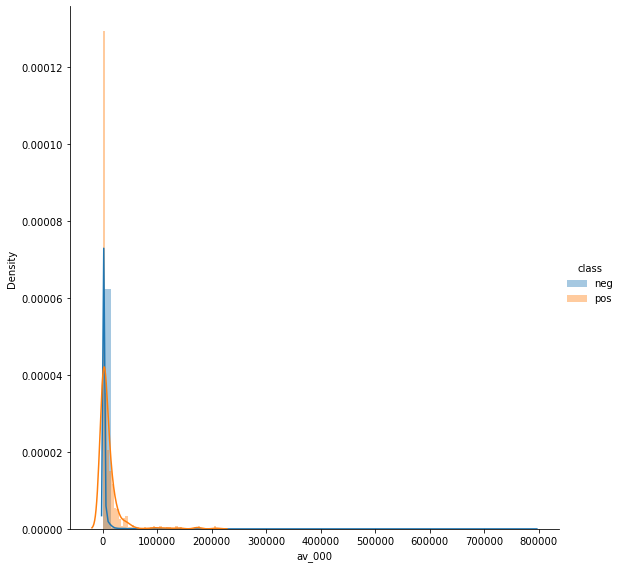

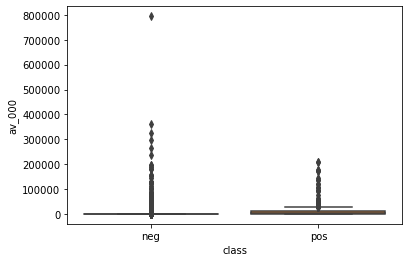

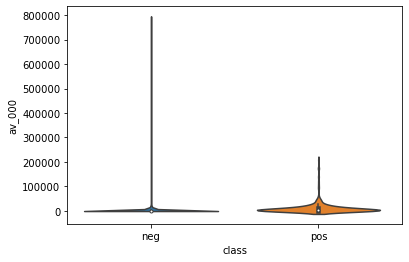

For Negative Class

median 112.0
mean 1006.3018595731954
std 6022.812703273043
quantile 0.25     12.0
0.50    112.0
0.75    628.0
Name: av_000, dtype: float64

For Positive Class

median 3346.0
mean 10737.156297420333
std 24034.164996782274
quantile 0.25        0.0
0.50     3346.0
0.75    11346.0
Name: av_000, dtype: float64


In [44]:
EDA('av_000')

## av_000
## Histogram and PDF- There is a slight difference between both the distributions.
## Box Plot and Viloin Plot- Nothing much can be inferred 
## Median and Mean- Positive Class has a much higher value than the Negative Class
## IQR -IQR of positive class is higher than the negative class

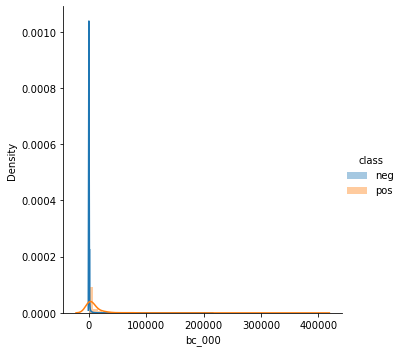

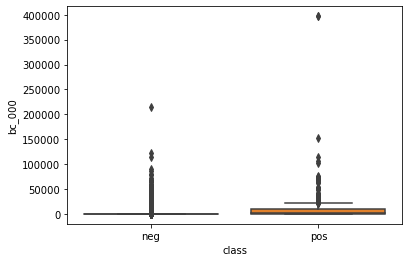

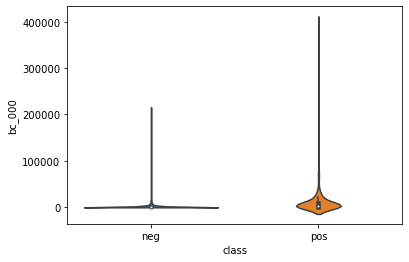

For Negative Class

median 14.0
median 469.29693567746943
std 2765.479291041695
quantile 0.25      0.0
0.50     14.0
0.75    130.0
Name: bc_000, dtype: float64

For Positive Class

median 2798.0
mean 9683.826645264848
std 26956.288568911234
quantile 0.25     542.0
0.50    2798.0
0.75    8939.0
Name: bc_000, dtype: float64


In [20]:
EDA('bc_000')

## av_000
## Histogram and PDF- There is a slight difference between both the distributions.
## Box Plot and Viloin Plot- Nothing much can be inferred 
## Median and Mean- Positive Class has a much higher value than the Negative Class
## IQR -IQR of positive class is higher than the negative class

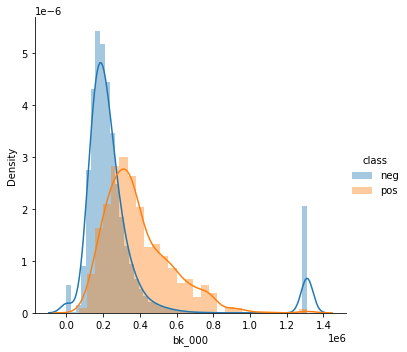

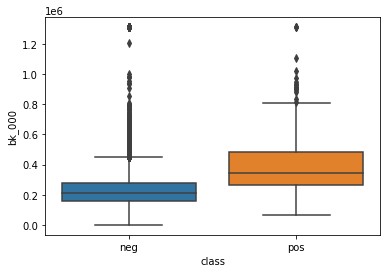

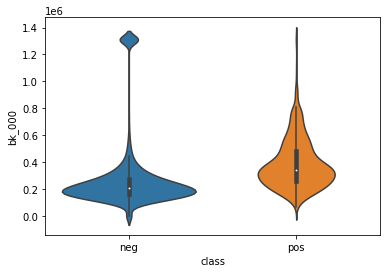

For Negative Class

median 208480.0
median 277635.39161809604
std 262501.1515204861
quantile 0.25    161740.0
0.50    208480.0
0.75    276355.0
Name: bk_000, dtype: float64

For Positive Class

median 344500.0
mean 387969.52991452994
std 179608.3455601632
quantile 0.25    261460.0
0.50    344500.0
0.75    481695.0
Name: bk_000, dtype: float64


In [21]:
EDA('bk_000')

## bk_000
## 1)Histogram and PDF- There is a slight overlap between both the distributions,positive class peaks at higher value than the negative class.
## 2)Box Plot and Viloin Plot- It can be seen that there is significant difference between both the classes, most of the positive datapoints have a higher value than the negative class.
## 3)Median and Mean- Positive Class has a much higher value than the Negative Class
## 4)IQR -IQR of positive class is higher than the negative class

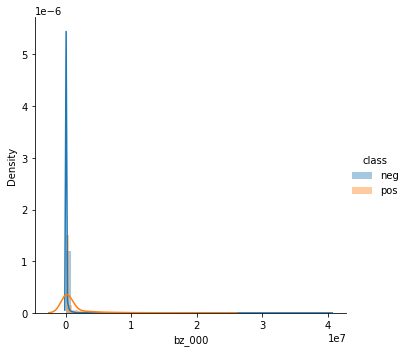

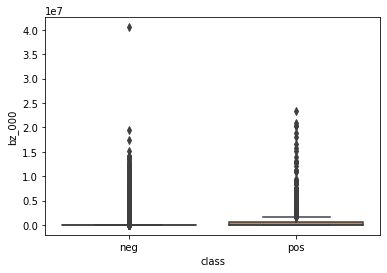

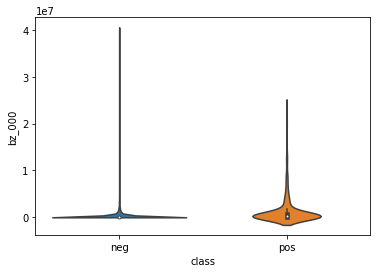

For Negative Class

median 1000.0
median 88701.69414339676
std 522817.5148766677
quantile 0.25        6.0
0.50     1000.0
0.75    12958.0
Name: bz_000, dtype: float64

For Positive Class

median 58082.0
mean 1307712.88282504
std 3170739.0612490345
quantile 0.25      2967.0
0.50     58082.0
0.75    667186.0
Name: bz_000, dtype: float64


In [23]:
EDA('bz_000')

## bz_000
## 1)Histogram and PDF- Nothing much can be inferred, as there is no significant difference between both the distributions
## 2)Box Plot and Viloin Plot- Nothing much can be inferred
## 3)Median and Mean- Positive Class has a  higher value than the Negative Class
## 4)IQR -IQR of positive class is higher than the negative class

# EDA of top 5 histogram features

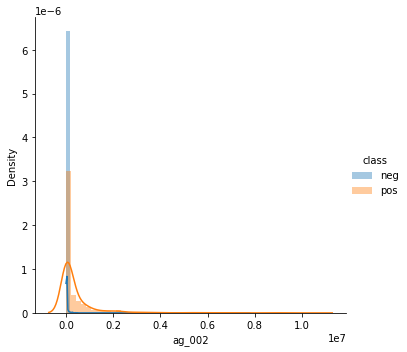

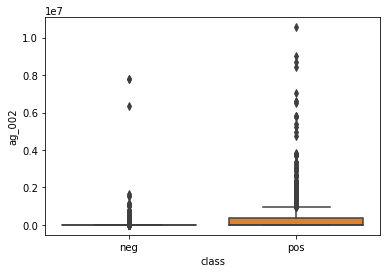

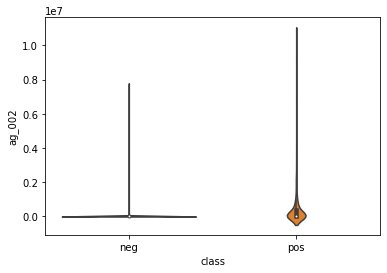

For Negative Class

median 0.0
mean 1915.646306550323
std 57119.82722471176
quantile 0.25    0.0
0.50    0.0
0.75    0.0
Name: ag_002, dtype: float64

For Positive Class

median 2208.0
mean 400442.6104417671
std 999882.7004554982
quantile 0.25         0.0
0.50      2208.0
0.75    376334.0
Name: ag_002, dtype: float64


In [35]:
EDA('ag_002')

## ag_002
## 1)Histogram and PDF- There is a slight overlap between both the distributions,most of the positive data points have higher value than the negative data points.
## 2)Box Plot and Viloin Plot- There is a slght difference between both the classes, most of the positive datapoints have a higher value than the negative class.
##   Few outliers are also there in both the classes
## 3)Median and Mean- Positive Class has a much higher value than the Negative Class
## 4)IQR -IQR of positive class is higher than the negative class

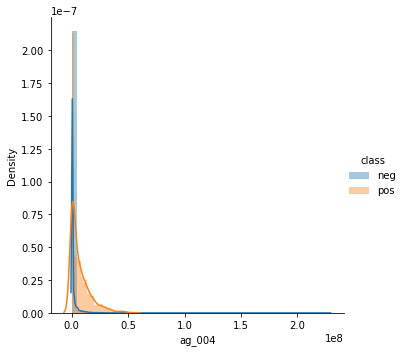

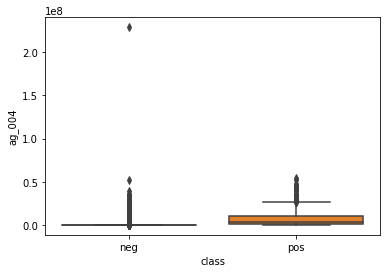

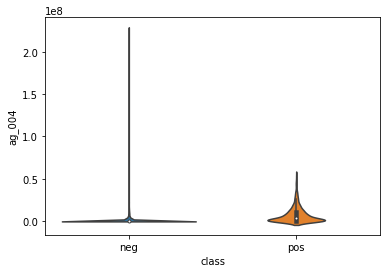

For Negative Class

median 3424.0
mean 321597.1260521489
std 1873956.8448951605
quantile 0.25      298.0
0.50     3424.0
0.75    44826.0
Name: ag_004, dtype: float64

For Positive Class

median 3731539.0
mean 7201587.297188755
std 9146813.415868295
quantile 0.25      541928.0
0.50     3731539.0
0.75    10812333.5
Name: ag_004, dtype: float64


In [34]:
EDA('ag_004')

## ag_004
## 1)Histogram and PDF- Positive class can be diffrentiated easily from the negative class, Positive points have higher values than the negative class.
## 2)Box Plot and Viloin Plot- Difference between both the classes can be observed, most of the positive datapoints have a higher value than the negative class.This feature has very few outliers.
## 3)Median and Mean- Positive Class has a much higher value than the Negative Class
## 4)IQR -IQR of positive class is higher than the negative class

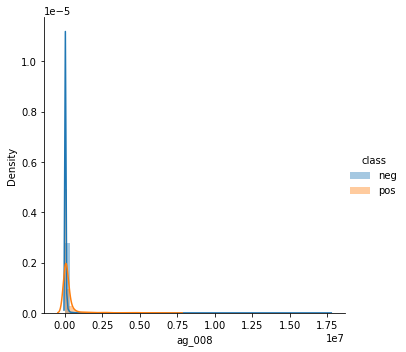

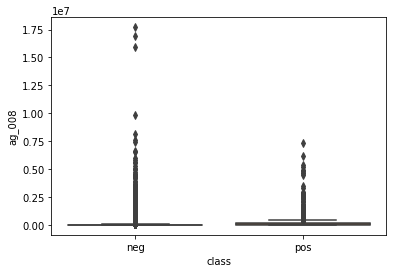

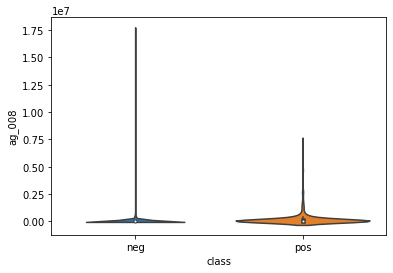

For Negative Class

median 1554.0
mean 32316.245418545248
std 204431.68197990116
quantile 0.25        0.0
0.50     1554.0
0.75    25610.0
Name: ag_008, dtype: float64

For Positive Class

median 50625.0
mean 226127.03212851405
std 634708.0932669311
quantile 0.25      7643.5
0.50     50625.0
0.75    169547.0
Name: ag_008, dtype: float64


In [33]:
EDA('ag_008')

## ag_008
## 1)Histogram and PDF- Nothing much can be inferred, as there is no significant difference between both the distributions.
## 2)Box Plot and Viloin Plot- Nothing much can be inferred, negative class has few outliers.
## 3)Median and Mean- Positive Class has a  higher value than the Negative Class.
## 4)IQR -IQR of positive class is higher than the negative class.

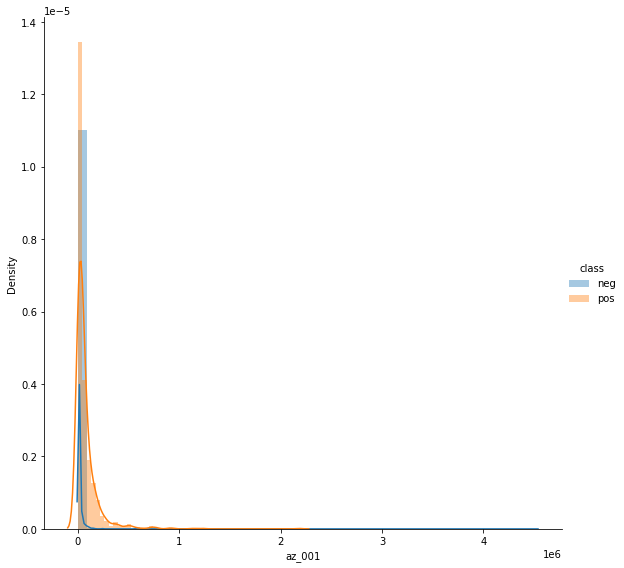

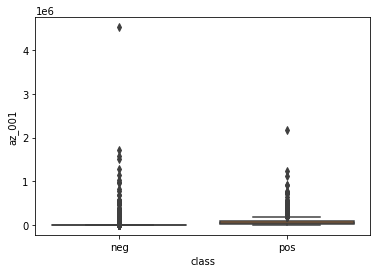

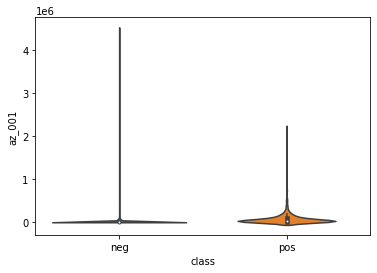

For Negative Class

median 614.0
mean 3247.100044570919
std 27951.583300807266
quantile 0.25      56.0
0.50     614.0
0.75    1904.0
Name: az_001, dtype: float64

For Positive Class

median 33522.0
mean 73242.93668341708
std 135300.40659773388
quantile 0.25    11092.0
0.50    33522.0
0.75    82933.0
Name: az_001, dtype: float64


In [45]:
EDA('az_001')

## az_001

## 1)Histogram and PDF- There is a slight overlap between both the distributions,most of the positive data points have higher value than the negative data points.
## 2)Box Plot and Viloin Plot-Most of the positive datapoints have a higher value than the Negative class, both the classes have outliers.
## 3)Median and Mean- Positive Class has a  higher value than the Negative Class
## 4)IQR -IQR of positive class is higher than the negative class

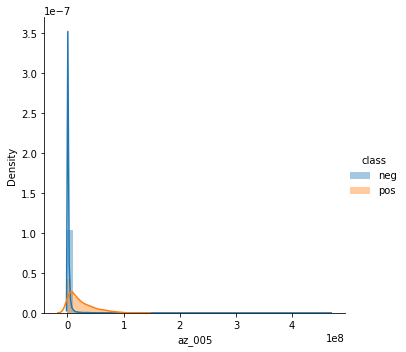

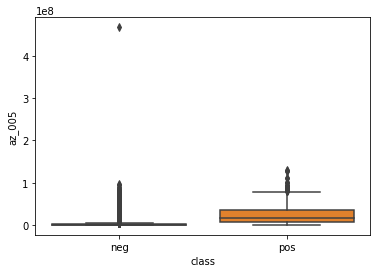

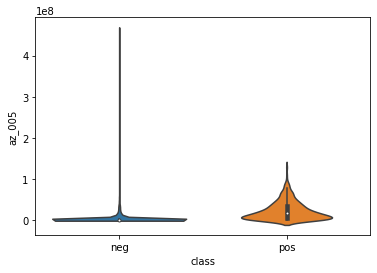

For Negative Class

median 505911.0
mean 1770157.8046422326
std 5076465.281332846
quantile 0.25      36445.5
0.50     505911.0
0.75    1690018.0
Name: az_005, dtype: float64

For Positive Class

median 16688128.0
mean 23559466.659296483
std 22612864.60714463
quantile 0.25     6202538.0
0.50    16688128.0
0.75    34992998.0
Name: az_005, dtype: float64


In [30]:
EDA('az_005')

## az_005

## 1)Histogram and PDF- There is a slight overlap between both the distributions,most of the positive data points have higher value than the negative data points.
## 2)Box Plot and Viloin Plot-Most of the positive datapoints have a higher value than the Negative class.
## 3)Median and Mean- Positive Class has a  higher value than the Negative Class
## 4)IQR -IQR of positive class is higher than the negative class

# Summary

# 1) Data is highly imbalanced. 
#    Number of Positive Data Points=1000
#    Number of Negative Data Points=59000
# 2) 7 Columns have more than 50% of its values missing
# 3) 1 column has std=0
# 4) 39 columns have correlation more than 90%
# 5) Some of the outliers belong to positive class, so outliers have not been removed considering the imbalance in the data set